# Covid-19 현황 분석
- data sorce : 
- https://github.com/owid/covid-19-data/raw/master/public/data/owid-covid-data.csv
- https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv
- https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv
- 선진국들과 대한민국의 코로나 현황 비교
- 시계열성 확인
- 국가별 지표를 통한 코로나 대응 분석

In [36]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt 
from matplotlib import font_manager, rc
import seaborn as sns 
from fbprophet import Prophet
sns.set_style("darkgrid")
%matplotlib inline 
rc("font", family="Malgun Gothic")
plt.rcParams["axes.unicode_minus"] = False 

import warnings
warnings.filterwarnings("ignore")

# Covid 데이터 가져오기

In [2]:
covid_df_all = pd.read_csv('https://github.com/owid/covid-19-data/raw/master/public/data/owid-covid-data.csv')
covid_df = covid_df_all.copy()

In [3]:
confirmed_df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv')
deaths_df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv')

In [4]:
print(confirmed_df.head(2))
print("-"*80)
print(deaths_df.head(2))
print("-"*80)
print(covid_df.head(2))

  Province/State Country/Region       Lat       Long  1/22/20  1/23/20  \
0            NaN    Afghanistan  33.93911  67.709953        0        0   
1            NaN        Albania  41.15330  20.168300        0        0   

   1/24/20  1/25/20  1/26/20  1/27/20  ...  10/7/21  10/8/21  10/9/21  \
0        0        0        0        0  ...   155429   155448   155466   
1        0        0        0        0  ...   173723   174168   174643   

   10/10/21  10/11/21  10/12/21  10/13/21  10/14/21  10/15/21  10/16/21  
0    155508    155540    155599    155627    155682    155688    155739  
1    174968    175163    175664    176172    176667    177108    177536  

[2 rows x 638 columns]
--------------------------------------------------------------------------------
  Province/State Country/Region       Lat       Long  1/22/20  1/23/20  \
0            NaN    Afghanistan  33.93911  67.709953        0        0   
1            NaN        Albania  41.15330  20.168300        0        0   

   1/24

# 한국, 프랑스, 영국, 미국, 일본 대상으로 데이터 추출

In [5]:
covid_df_county_list1 = ["Korea, South", "France", "United Kingdom", "US", "Japan"]
covid_df_county_list2 = ["South Korea", "France", "United Kingdom", "United States", "Japan"]

In [6]:
confirmed_df = confirmed_df.loc[confirmed_df['Country/Region'].isin(covid_df_county_list1)]
deaths_df = deaths_df.loc[deaths_df['Country/Region'].isin(covid_df_county_list1)]

covid_df = covid_df.loc[covid_df['location'].isin(covid_df_county_list2)]

In [7]:
print(confirmed_df.head(2))
print("-"*80)
print(deaths_df.head(2))
print("-"*80)
print(covid_df.head(2))

       Province/State Country/Region      Lat      Long  1/22/20  1/23/20  \
119     French Guiana         France   3.9339  -53.1258        0        0   
120  French Polynesia         France -17.6797  149.4068        0        0   

     1/24/20  1/25/20  1/26/20  1/27/20  ...  10/7/21  10/8/21  10/9/21  \
119        0        0        0        0  ...    41956    42157    42157   
120        0        0        0        0  ...    45181    45359    45359   

     10/10/21  10/11/21  10/12/21  10/13/21  10/14/21  10/15/21  10/16/21  
119     42157     42157     42157     42794     42962     43255     43255  
120     45359     45359     45359     45359     45439     45439     45439  

[2 rows x 638 columns]
--------------------------------------------------------------------------------
       Province/State Country/Region      Lat      Long  1/22/20  1/23/20  \
119     French Guiana         France   3.9339  -53.1258        0        0   
120  French Polynesia         France -17.6797  149.4068

In [8]:
# Datetime 형식으로 치환
tmp_col = confirmed_df.columns[:4]
val_col = confirmed_df.columns[4:]

confirmed_df = confirmed_df.melt(id_vars = tmp_col)
confirmed_df = confirmed_df.rename(columns = {"variable" : "Datetime"})
confirmed_df["Datetime"] = pd.to_datetime(confirmed_df["Datetime"], format = "%m/%d/%y")

###
tmp_col = deaths_df.columns[:4]
val_col = deaths_df.columns[4:]

deaths_df = deaths_df.melt(id_vars = tmp_col)
deaths_df = deaths_df.rename(columns = {"variable" : "Datetime"})
deaths_df["Datetime"] = pd.to_datetime(deaths_df["Datetime"], format = "%m/%d/%y")


In [9]:
covid_df_all["date"] = pd.to_datetime(covid_df_all["date"], format = "%Y-%m-%d")
covid_df_all = covid_df_all.loc[covid_df_all['date'] <= "2021-09-30"]

covid_df["date"] = pd.to_datetime(covid_df["date"], format = "%Y-%m-%d")
covid_df = covid_df.loc[covid_df['date'] <= "2021-09-30"]

In [10]:
# 1000단위로 단위 변경
confirmed_df['value'] = confirmed_df['value']/1000
deaths_df['value'] = deaths_df['value']/1000

In [11]:
# Grouping
confirmed_df = confirmed_df[["Country/Region", "Datetime", "value"]].groupby(["Country/Region", "Datetime"]).sum().reset_index()
deaths_df = deaths_df[["Country/Region", "Datetime", "value"]].groupby(["Country/Region", "Datetime"]).sum().reset_index()

In [12]:
print(confirmed_df.head(2))
print("-"*80)
print(deaths_df.head(2))
print("-"*80)

  Country/Region   Datetime  value
0         France 2020-01-22    0.0
1         France 2020-01-23    0.0
--------------------------------------------------------------------------------
  Country/Region   Datetime  value
0         France 2020-01-22    0.0
1         France 2020-01-23    0.0
--------------------------------------------------------------------------------


# 각 국가별 데이터 코로나 현황 시각화

In [13]:
def drawConfirmed_Cum(idx):
    confirmed_df_plt = confirmed_df[["Country/Region", "Datetime", "value"]]
    country = covid_df_county_list1[idx]

    confirmed_df_plt = confirmed_df_plt.loc[confirmed_df_plt["Country/Region"] == country]
    confirmed_df_plt = confirmed_df_plt.sort_values("Datetime").reset_index(drop=True)
    confirmed_df_plt["cumValue"] = confirmed_df_plt["value"].cumsum()


    fig, ax1 = plt.subplots(figsize=(10, 6))
    plt.title(country + " : Confirmed & Cum Confirmed    (단위 1,000 명)")
    color = 'tab:red'
    ax1.set_xlabel("Date")
    ax1.set_ylabel('Confirmed', color=color)
    ax1.plot(confirmed_df_plt["Datetime"],
             confirmed_df_plt["value"],
             ":",
             color=color)
    ax1.tick_params(axis='y', labelcolor=color)
    
    
    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

    color = 'tab:blue'
    ax2.set_ylabel('Cum Confirmed', color=color)  # we already handled the x-label with ax1
    ax2.plot(confirmed_df_plt["Datetime"],
             confirmed_df_plt["cumValue"],
             color=color)
    ax2.tick_params(axis='y', labelcolor=color)
    ax2.fill_between(confirmed_df_plt["Datetime"], 0, confirmed_df_plt["cumValue"], alpha=0.50)

    ax1.grid(True)
    ax2.grid(False)
    
    # after plotting the data, format the labels
    current_values = plt.gca().get_yticks()
    plt.gca().set_yticklabels(['{:,.0f}'.format(x) for x in current_values])
    
    fig.tight_layout()  # otherwise the right y-label is slightly clipped

    plt.show()

### 각 나라별 확진자 & 누적 확진자 추이

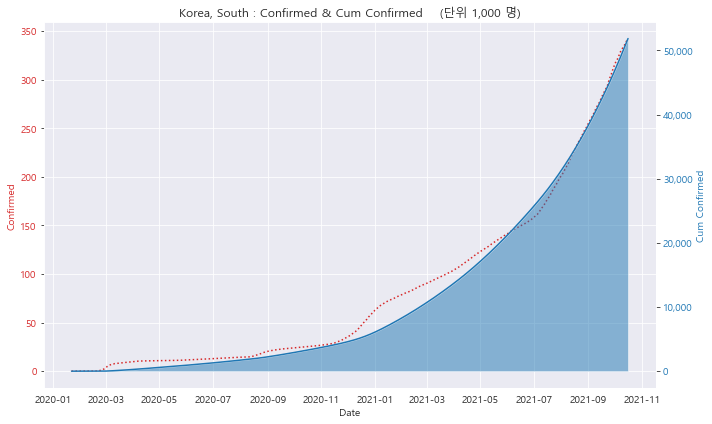

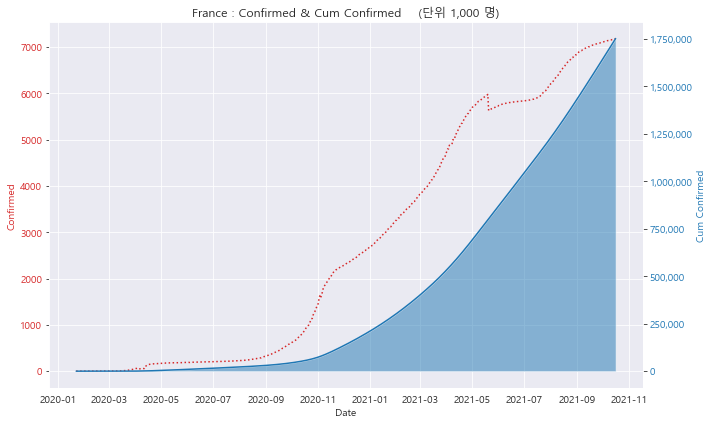

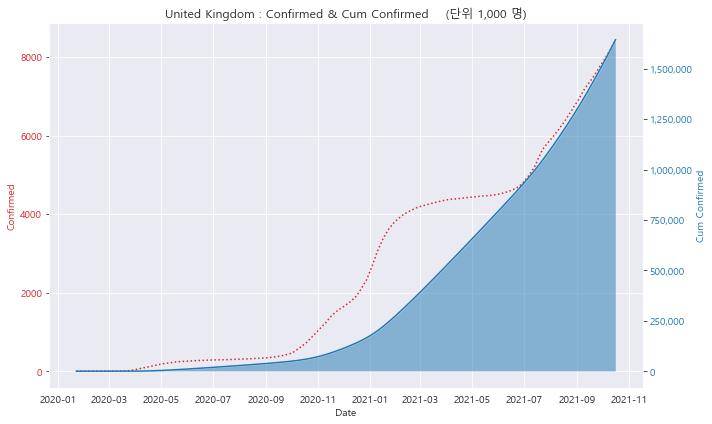

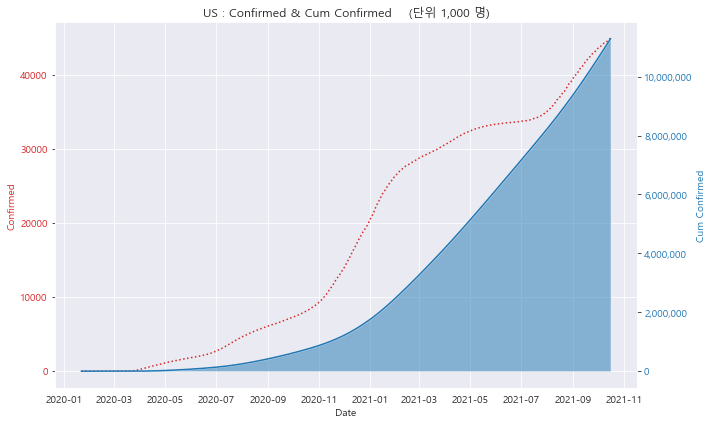

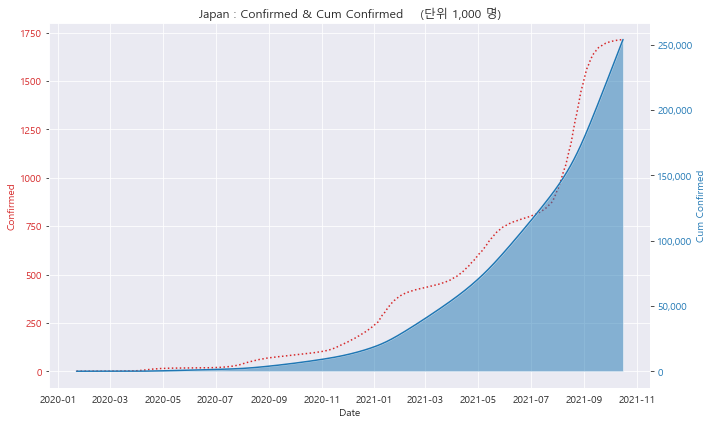

In [14]:
for i in range(0,len(covid_df_county_list1)):
    drawConfirmed_Cum(i)

In [15]:
def drawDeaths_Cum(idx):
    deaths_df_plt = deaths_df[["Country/Region", "Datetime", "value"]]
    country = covid_df_county_list1[idx]

    deaths_df_plt = deaths_df_plt.loc[deaths_df_plt["Country/Region"] == country]
    deaths_df_plt = deaths_df_plt.sort_values("Datetime").reset_index(drop=True)
    deaths_df_plt["cumValue"] = deaths_df_plt["value"].cumsum()


    fig, ax1 = plt.subplots(figsize=(10, 6))
    plt.title(country + " : Deaths & Cum Deaths    (단위 1,000 명)")
    color = 'tab:red'
    ax1.set_xlabel("Date")
    ax1.set_ylabel('Deaths', color=color)
    ax1.plot(deaths_df_plt["Datetime"],
             deaths_df_plt["value"],
             ":",
             color=color)
    ax1.tick_params(axis='y', labelcolor=color)
    
    
    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

    color = 'tab:blue'
    ax2.set_ylabel('Cum Deaths', color=color)  # we already handled the x-label with ax1
    ax2.plot(deaths_df_plt["Datetime"],
             deaths_df_plt["cumValue"],
             color=color)
    ax2.tick_params(axis='y', labelcolor=color)
    ax2.fill_between(deaths_df_plt["Datetime"], 0, deaths_df_plt["cumValue"], alpha=0.50)

    ax1.grid(True)
    ax2.grid(False)
    
    # after plotting the data, format the labels
    current_values = plt.gca().get_yticks()
    plt.gca().set_yticklabels(['{:,.0f}'.format(x) for x in current_values])
    
    fig.tight_layout()  # otherwise the right y-label is slightly clipped

    plt.show()

### 각 나라별 사망자 & 누적 사망자 추이

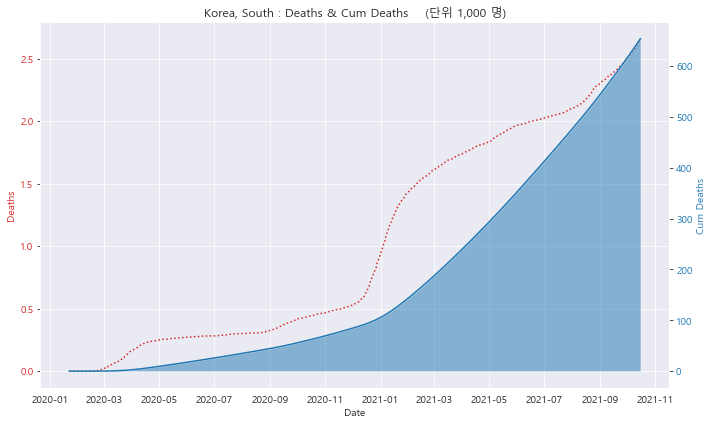

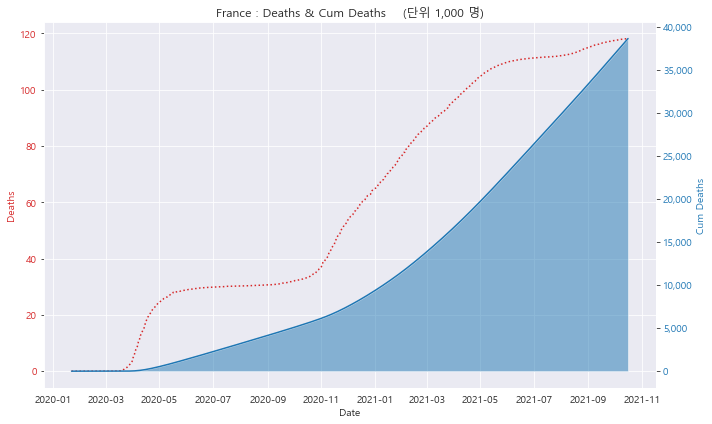

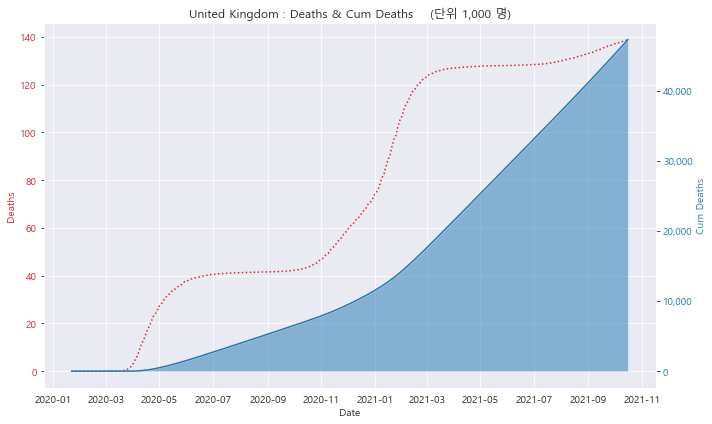

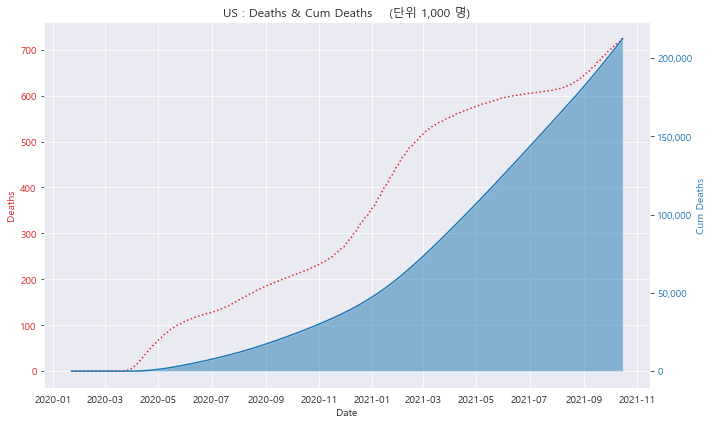

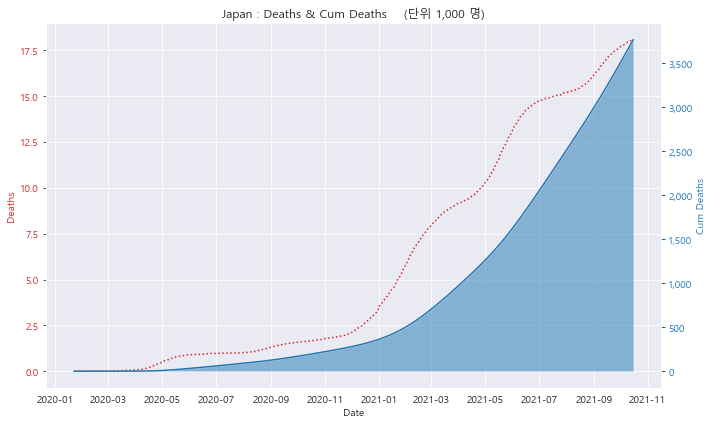

In [16]:
for i in range(0,len(covid_df_county_list1)):
    drawDeaths_Cum(i)

### 각 나라별 사회적 거리두기 지표 대비 새 확진자 수
- 사회적 거리두기와 공공 캠페인 정책을 종합하여 상대적 비율(%)을 산출한 정부 대응 엄격성 지표(Government)
- Stringency Index; 100 = 가장 엄격한 대응
- 확진자 수 per(million) (7 day smoothed)

In [17]:
def drawStringencyCases(idx):
    country = covid_df_county_list2[idx]
    
    covid_df_plt = covid_df.loc[covid_df["location"] == country]
    covid_df_plt = covid_df_plt.sort_values("date").reset_index(drop=True)
    
    fig, ax1 = plt.subplots(figsize=(10, 6))
    plt.title(country + " :  stringency index & new cases")
    color = 'tab:red'
    ax1.set_xlabel("Date")
    ax1.set_ylabel('stringency index', color=color)
    ax1.set_ylim([0, 100])
    ax1.plot(covid_df_plt["date"],
             covid_df_plt["stringency_index"],
             ":",
             color=color)
    ax1.tick_params(axis='y', labelcolor=color)


    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

    color = 'tab:blue'
    ax2.set_ylabel('new cases', color=color)  # we already handled the x-label with ax1
    ax2.plot(covid_df_plt["date"],
             covid_df_plt["new_cases_smoothed_per_million"],
             color=color)
    ax2.tick_params(axis='y', labelcolor=color)
    # ax2.set_ylim([0, 1000])

    ax1.grid(True)
    ax2.grid(False)

    # after plotting the data, format the labels
    current_values = plt.gca().get_yticks()
    plt.gca().set_yticklabels(['{:,.0f}'.format(x) for x in current_values])

    fig.tight_layout()  # otherwise the right y-label is slightly clipped

    plt.show()

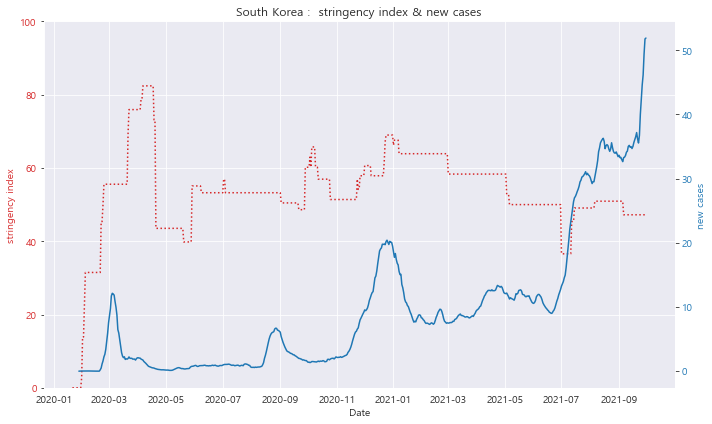

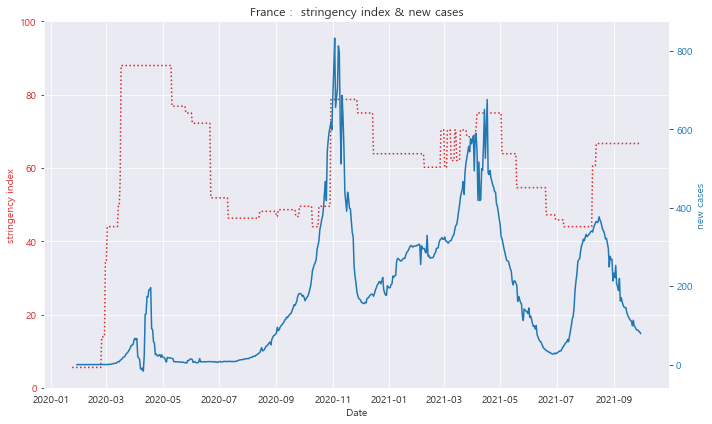

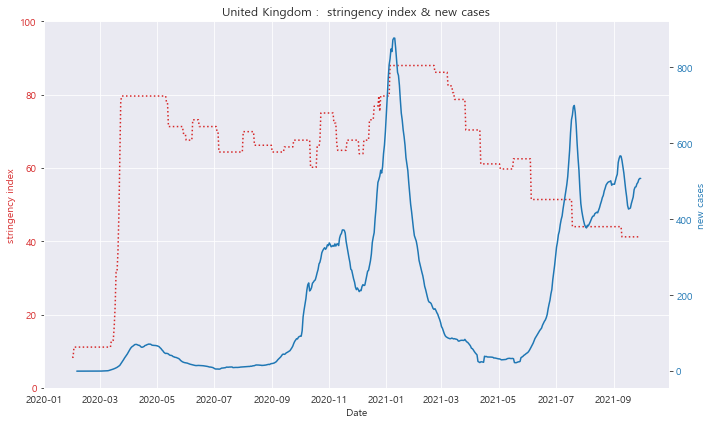

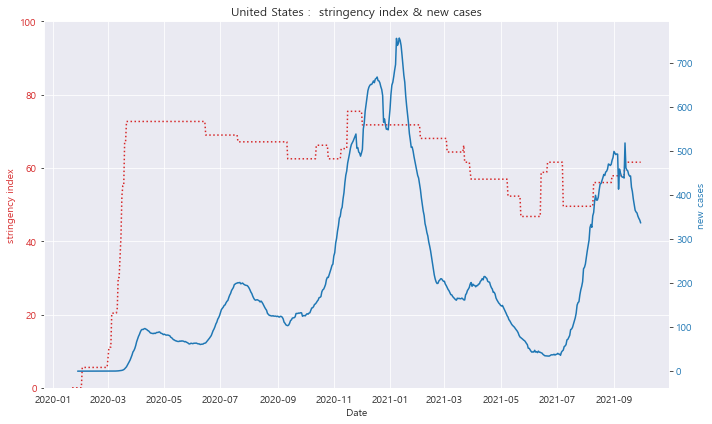

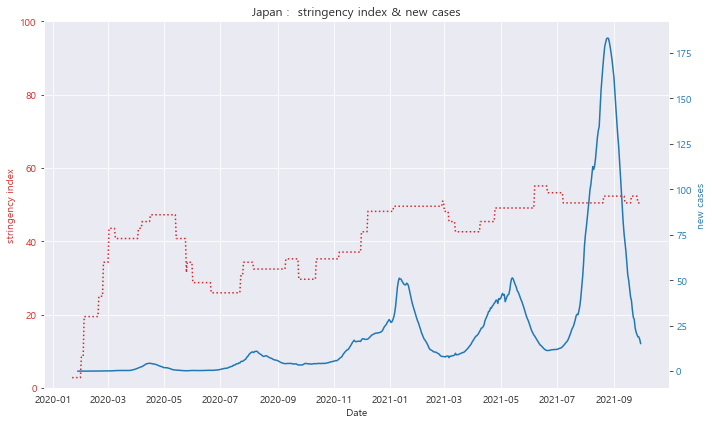

In [18]:
for i in range(0,len(covid_df_county_list2)):
    drawStringencyCases(i)

- 대부분의 국가들이 신규 확진자가 급격하게 늘어나는 시점에 사회적 거리두기 지표가 증가하는 것을 확인 할 수 있다.
- 일본을 제외한 국가들은 코로나 초기에 강한 거리두기 지표를 보이며 신규 감염을 억제한 것으로 보인다.
- 일본의 경우에는 비교적 낮은 강도의 지표를 보이는데 반해 낮은 신규 확진자를 유지하다 21년 9월경 심해졌다가 지금은 낮은 수치를 보인다

# 인구수별 비율로 각 국가별 데이터 시각화
## 2020년 기준 국가별 총 인구수 대비 확진자 비율
- 신규 확진자 비율(%) = 신규 확진자 수 (7 day smoothed) / 총 인구수 * 100

In [19]:
covid_df["new_cases_smoothed_popu"] = covid_df['new_cases_smoothed'] / covid_df['population'] * 100

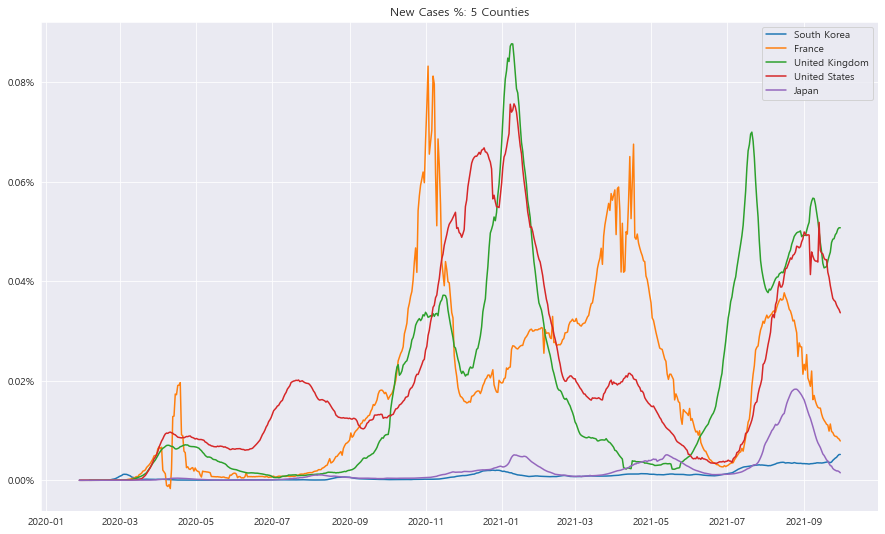

In [20]:
plt.figure(figsize=(15, 9))
plt.title("New Cases %: 5 Counties")

for idx in range(0,len(covid_df_county_list2)):
    country = covid_df_county_list2[idx]

    covid_df_plt = covid_df.loc[covid_df["location"] == country]
    covid_df_plt = covid_df_plt.sort_values("date").reset_index(drop=True)
    plt.plot(covid_df_plt["date"],
             covid_df_plt["new_cases_smoothed_popu"])
plt.legend(covid_df_county_list2)
plt.grid(True)
# after plotting the data, format the labels
current_values = plt.gca().get_yticks()
plt.gca().set_yticklabels(['{:.2f}%'.format(x) for x in current_values])
    
plt.show()

- 한국, 일본의 경우 신규 확진자가 인구 대비 큰 폭으로 늘어나지 않는 반면
- 다른 국가에서는 변동 폭이 큰 것으로 보인다

# 시계열성 확인

--------------------------------------------------------------------------------
South Korea>>>


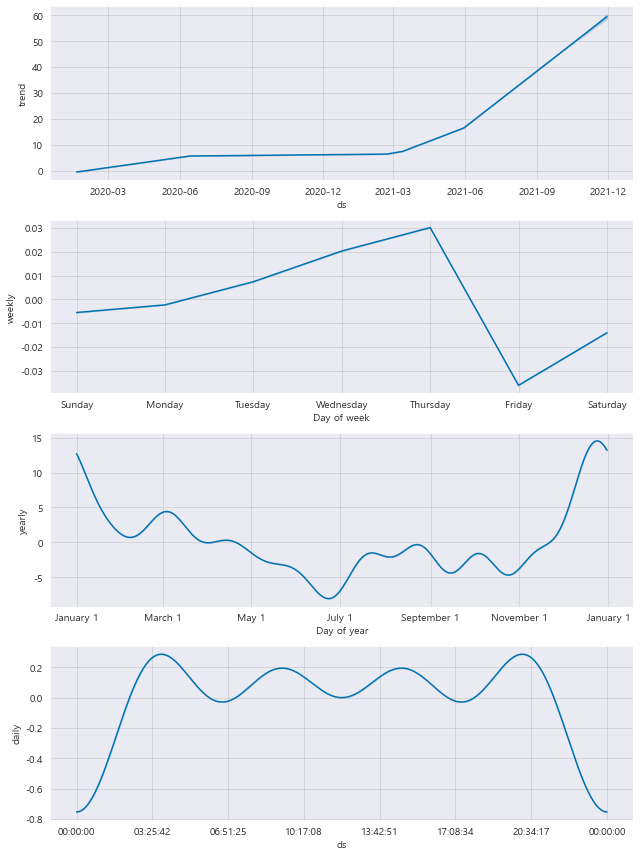

In [21]:
print("-"*80)
idx = 0
country = covid_df_county_list2[idx]
print(country+">>>")
covid_df_TS = covid_df.loc[covid_df["location"] == country][["date", "new_cases_smoothed_per_million"]]
covid_df_TS = covid_df_TS.sort_values('date').reset_index(drop=True)
covid_df_TS.columns = ["ds", "y"]

    m = Prophet(yearly_seasonality=True, daily_seasonality=True)
m.fit(covid_df_TS);

future = m.make_future_dataframe(periods=60)
forecast = m.predict(future)

m.plot_components(forecast);

--------------------------------------------------------------------------------
France>>>


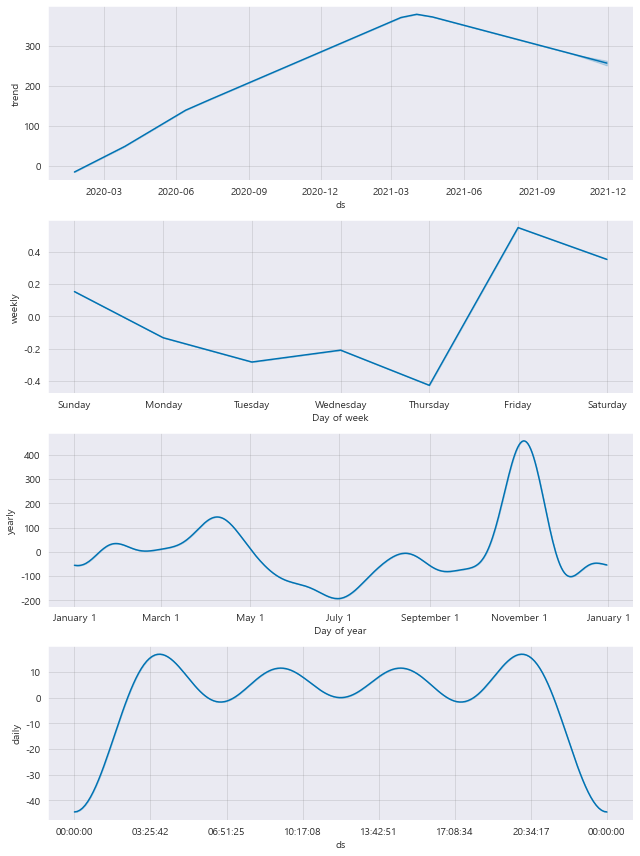

In [22]:
print("-"*80)
idx = 1
country = covid_df_county_list2[idx]
print(country+">>>")
covid_df_TS = covid_df.loc[covid_df["location"] == country][["date", "new_cases_smoothed_per_million"]]
covid_df_TS = covid_df_TS.sort_values('date').reset_index(drop=True)
covid_df_TS.columns = ["ds", "y"]

m = Prophet(yearly_seasonality=True, daily_seasonality=True)
m.fit(covid_df_TS);

future = m.make_future_dataframe(periods=60)
forecast = m.predict(future)

m.plot_components(forecast);

--------------------------------------------------------------------------------
United Kingdom>>>


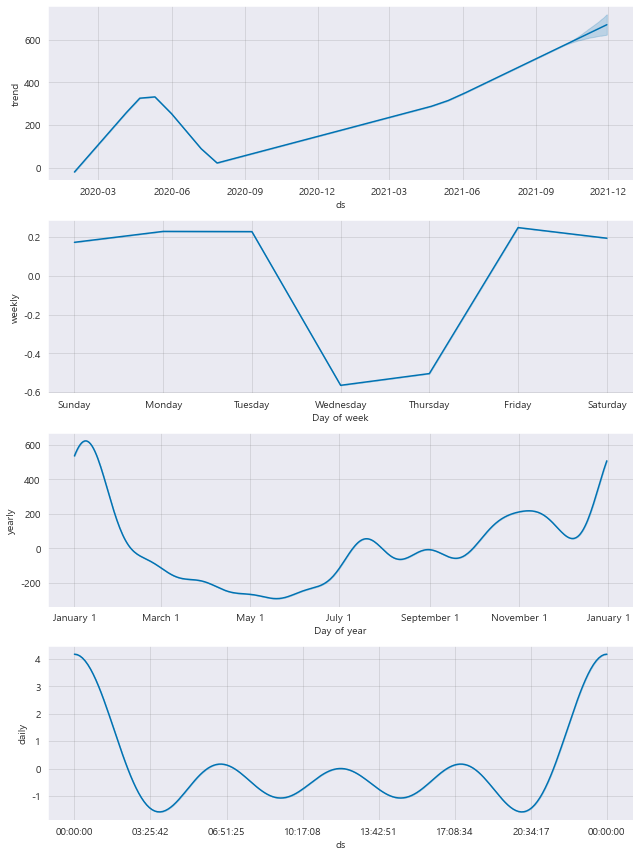

In [23]:
print("-"*80)
idx = 2
country = covid_df_county_list2[idx]
print(country+">>>")
covid_df_TS = covid_df.loc[covid_df["location"] == country][["date", "new_cases_smoothed_per_million"]]
covid_df_TS = covid_df_TS.sort_values('date').reset_index(drop=True)
covid_df_TS.columns = ["ds", "y"]

m = Prophet(yearly_seasonality=True, daily_seasonality=True)
m.fit(covid_df_TS);

future = m.make_future_dataframe(periods=60)
forecast = m.predict(future)

m.plot_components(forecast);

--------------------------------------------------------------------------------
United States>>>


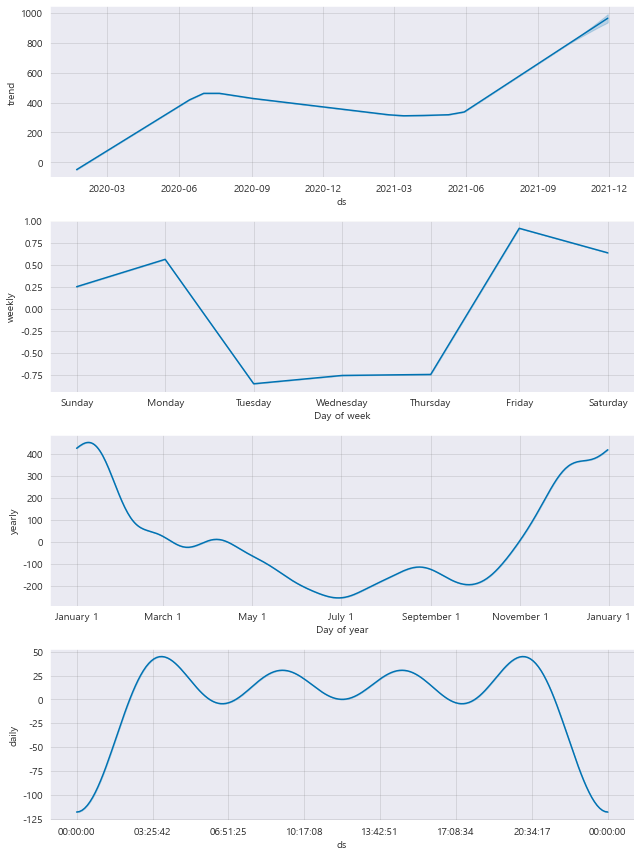

In [24]:
print("-"*80)
idx = 3
country = covid_df_county_list2[idx]
print(country+">>>")
covid_df_TS = covid_df.loc[covid_df["location"] == country][["date", "new_cases_smoothed_per_million"]]
covid_df_TS = covid_df_TS.sort_values('date').reset_index(drop=True)
covid_df_TS.columns = ["ds", "y"]

m = Prophet(yearly_seasonality=True, daily_seasonality=True)
m.fit(covid_df_TS);

future = m.make_future_dataframe(periods=60)
forecast = m.predict(future)

m.plot_components(forecast);

--------------------------------------------------------------------------------
Japan>>>


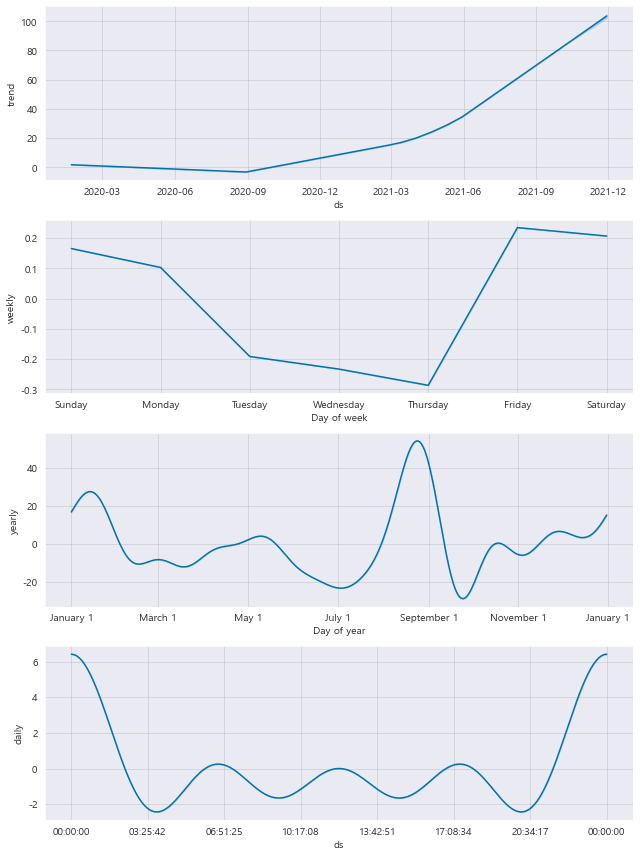

In [25]:
print("-"*80)
idx = 4
country = covid_df_county_list2[idx]
print(country+">>>")
covid_df_TS = covid_df.loc[covid_df["location"] == country][["date", "new_cases_smoothed_per_million"]]
covid_df_TS = covid_df_TS.sort_values('date').reset_index(drop=True)
covid_df_TS.columns = ["ds", "y"]

m = Prophet(yearly_seasonality=True, daily_seasonality=True)
m.fit(covid_df_TS);

future = m.make_future_dataframe(periods=60)
forecast = m.predict(future)

m.plot_components(forecast);

## 신규 확진자의 시계열 Trend와 Weekday별 특성이 모두 상이 한 것 같다...
- 시계열성을 찾기가 힘든 것으로 생각

# 4개 국가 와 우리나라 비교

## 국가 별 백신 접종률

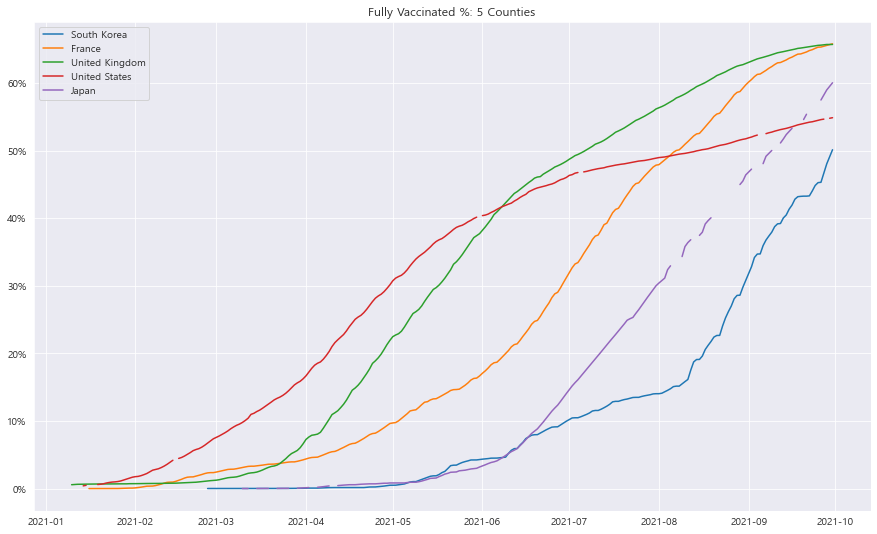

In [26]:
plt.figure(figsize=(15, 9))
plt.title("Fully Vaccinated %: 5 Counties")

for idx in range(0,len(covid_df_county_list2)):
    country = covid_df_county_list2[idx]

    covid_df_plt = covid_df.loc[covid_df["location"] == country]
    covid_df_plt = covid_df_plt.sort_values("date").reset_index(drop=True)
    plt.plot(covid_df_plt["date"],
             covid_df_plt["people_fully_vaccinated_per_hundred"])
plt.legend(covid_df_county_list2)
plt.grid(True)
# after plotting the data, format the labels
current_values = plt.gca().get_yticks()
plt.gca().set_yticklabels(['{:.0f}%'.format(x) for x in current_values])
    
plt.show()

- 백신 접종이 빠르게 시간된 것은 미국 > 영국 > 프랑스 > 일본 > 한국 순
- 한국의 백신 접종률은 다른 국가들에 비해 저조해 보인다
- 미국의 경우에는 초반 접종률에 비해 현재 접종률 상승이 더뎌 보인다
- 영국과 프랑스의 경우에는 다른 국가들에 비해 빠른 접종률을 보이는 듯 하다

## 9/30 기준 백신 접종률

In [27]:
for idx in range(0,len(covid_df_county_list2)):
    country = covid_df_county_list2[idx]
    covid_df_plt = covid_df.loc[covid_df["location"] == country]
    covid_df_plt = covid_df_plt.sort_values("date").reset_index(drop=True)
    print(country+" : " + str(covid_df_plt["people_fully_vaccinated_per_hundred"].max()) + "%")

South Korea : 50.15%
France : 65.83%
United Kingdom : 65.73%
United States : 54.89%
Japan : 60.06%


- 9/30 기준 백신 접종률은 프랑스 = 영국 > 일본 > 미국 > 한국 순
## 한국은 백신 접종률 시작속도와 백신 접종률이 5개 국 중 가장 뒤쳐저 있는 것으로 보인다

# 국가 별 인구 수 대비 코로나 사망자

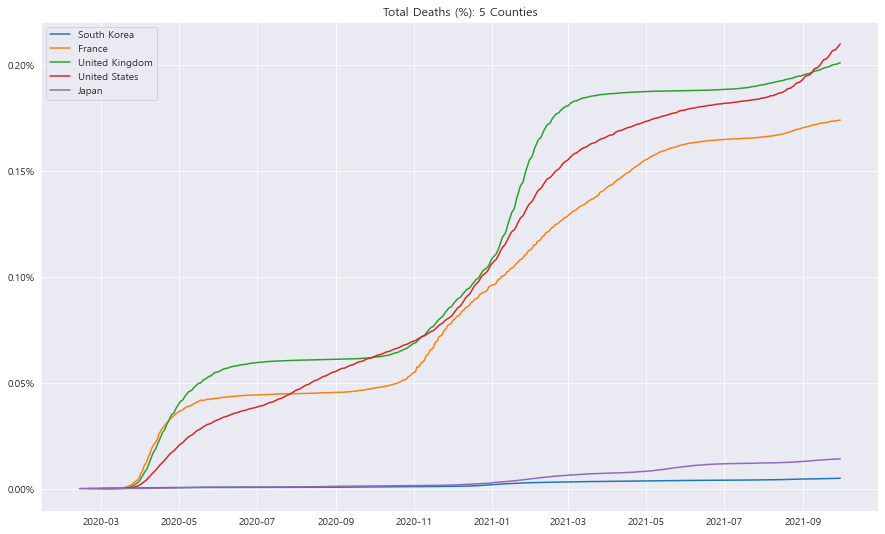

In [28]:
plt.figure(figsize=(15, 9))
plt.title("Total Deaths (%): 5 Counties")

for idx in range(0,len(covid_df_county_list2)):
    country = covid_df_county_list2[idx]

    covid_df_plt = covid_df.loc[covid_df["location"] == country]
    covid_df_plt = covid_df_plt.sort_values("date").reset_index(drop=True)
    plt.plot(covid_df_plt["date"],
             covid_df_plt["total_deaths"]/covid_df_plt["population"]* 100)
plt.legend(covid_df_county_list2)
plt.grid(True)
# after plotting the data, format the labels
current_values = plt.gca().get_yticks()
plt.gca().set_yticklabels(['{:.2f}%'.format(x) for x in current_values])
    
plt.show()

- 9/30 기준 미국 > 영국 > 프랑스 > 일본 > 한국 순
- 코로나 사망자 비율을 한국이 제일 낮다

#### 한국은 백신 접종률이 다른 나라에 비해 저조하지만
#### 코로나 사망률은 적은 것을 알 수 있다

# Covid19와 의료수준 관련 확인

In [29]:
covid_df_plt = covid_df.loc[(covid_df["date"] == "2021-09-30")]

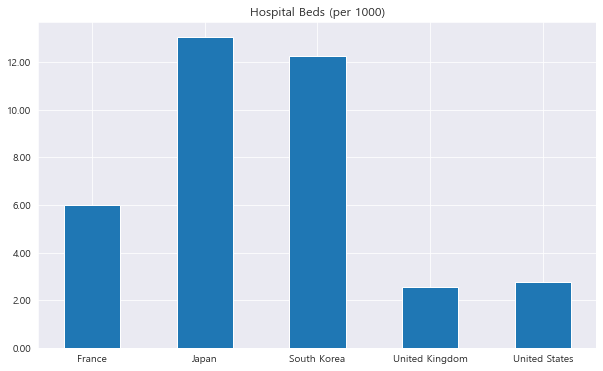

In [30]:
plt.figure(figsize=(10, 6))
plt.title("Hospital Beds (per 1000)")

plt.bar(covid_df_plt["location"],
         covid_df_plt["hospital_beds_per_thousand"],
         width = 0.5)
plt.grid(True)
# after plotting the data, format the labels
current_values = plt.gca().get_yticks()
plt.gca().set_yticklabels(['{:.2f}'.format(x) for x in current_values])
    
plt.show()

- 한국의 1000명당 병상의 수는 12.2개로 일본 > 한국 > 프랑스 > 미국 > 영국 순으로 2등이다

## 9/30 기준 누적 사망자를 확인

In [31]:
deaths_df_plt = deaths_df.copy()
deaths_df_plt["cumValue"] = deaths_df_plt["value"].cumsum()
deaths_df_plt = deaths_df_plt.loc[deaths_df_plt["Datetime"] == "2021-09-30"]

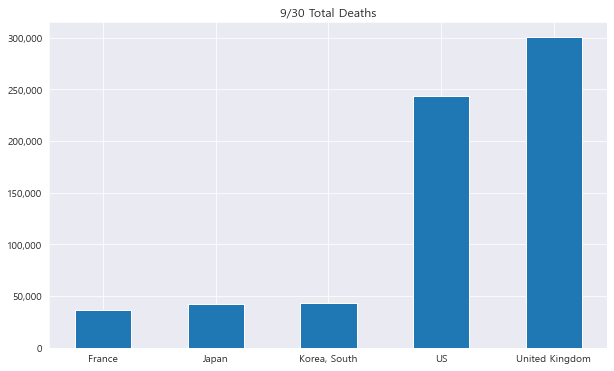

In [32]:
plt.figure(figsize=(10, 6))
plt.title("9/30 Total Deaths")

plt.bar(deaths_df_plt["Country/Region"],
         deaths_df_plt["cumValue"],
         width = 0.5)
plt.grid(True)
# after plotting the data, format the labels
current_values = plt.gca().get_yticks()
plt.gca().set_yticklabels(['{:,.0f}'.format(x) for x in current_values])
    
plt.show()

In [33]:
g20_list_ex_china = ['South Korea', 'Japan', 'Indonesia', 'United Kingdom', 'Italy', 'Germany',
                     'France', 'South Africa', 'Spain', 'Mexico', 'Brazil', 'Turkey', 'Argentina',
                     'India', 'Russia', 'United States', 'Saudi Arabia', 'Canada', 'Australia']

In [34]:
covid_df_all_corr = covid_df_all[["location","date", "population", "total_deaths", "hospital_beds_per_thousand"]]
covid_df_all_corr = covid_df_all_corr.loc[(covid_df_all_corr["date"] == "2021-09-30") &
                                         covid_df_all_corr["location"].isin(g20_list_ex_china)].reset_index(drop=True)
covid_df_all_corr = covid_df_all_corr.dropna(how='any')
covid_df_all_corr["total_deaths_popu"] = covid_df_all_corr["total_deaths"]/covid_df_all_corr["population"]* 100

In [35]:
covid_df_all_corr[["hospital_beds_per_thousand", "total_deaths_popu"]].corr()

,hospital_beds_per_thousand,total_deaths_popu
hospital_beds_per_thousand,1.000000,-0.319319
total_deaths_popu,-0.319319,1.000000


- G20 국가 (excl. China) 대상으로 9/30 병상 수와 인구 대비 코로나 사망률을 확인
- 병상의 수와 인구 대비 코로나 사망률은 음적 상관관계가 있는 것으로 보인다

#### 지금까지의 분석으로 한국의 의료수준(병상 수)는 상위권에 위치하고
#### 이와 더불어 코로나 사망률이 다른 국가 대비 적은 상관성이 확인 된다

# 결론 : 
- 한국은 다른 국가들과 같이 코로나 초반에 강한 사회적 거리두기 지표로 확진자 수를 최초화 한 것 으로 보인다.
- 하지만 최근 7월 부터 데이터를 보면 사회적 거리두기 지표가 확진자 수 감소에 영향이 있다고 말할 수는 없을 것 같다.
- 한국의 의료 수준은 상위권 수준이고 코로나 사망률이 낮은 것과 관계가 있어 보인다.
- 백신 접종 속도 & 접종률은 아직 다른 국가에 비해 뒤쳐져 있다.